Data Set Information:

The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study

(1) sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects, (2) the transferability of models among domains, i.e. conditions, and (3) the transferability of models among different data sources (see 'Drug Review Dataset (Druglib.com)').

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

Link: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

Let us do sentiment analysis with the intention of frequent words used while rating lower (2 or 3 or 4)

In [1]:
##############################################################################################
#                  STEPS IN MULTI CLASS CLASSIFICATION - SENTIMENT ANALYSIS
##############################################################################################

#STEP ONE: Load libraries and the Training/Testing data

#STEP TWO: Data Exploration
#          (a) Shape of Training and Testing dataset
#          (b) Presence of NAs in the dataset and if found, exclude these rows
#          (c) Number of unique entries in each of the columns in the training and testing dataset
#          (d) Target variable - Ratings; Features - Reviews in the training dataset
#          (e) Check distribution of ratings in the training dataset (Balanced means equitable distribution else imbalanced)
#          (f) Top 5 medical conditions and distribution of ratings in the training dataset
#          (g) Top 5 drugs and distribution of ratings in the training dataset
#          (h) Check for duplicate rows in the dataset and if found, drop these rows
#          (i) Explore reviews column - Total words , vocabulary - Original dataset, after dropping NAs, after dropping duplicates

#STEP THREE: Data Preprocessing - For each Review
#          (a) Check and remove tags, punctuation marks, special characters, numbers
#          (b) Check and remove single character, empty and multiple spaces, stop words
#          (c) After preprocessing, tokenize the sentences and convert into sequences
#          (d) Only reviews pertaining to ratings of 2,3,4 are considered for training 

#STEP FOUR: Model Selection in Neural Network Classifier 
#          (a) Basic keras model
#          (b) Add GlobalMaxPooling 1D layer
#          (c) GloVe Word Embedding (non-trainable)
#          (d) GloVe Word Embedding (trainable)
#          (e) CNN with vocabulary of 5000
#          (f) CNN with corpus vocabulary
#          (g) LSTM
#          (h) Bidirectional LSTM
#          (i) Select best model based on training and validation accuracy

#STEP FIVE: Prepare Test data
#           (a) Check for NAs and duplicates in test data, if found remove them
#           (b) Preprocess the test data so that reviews do not have tags, stop words, punctuation marks, numbers etc.
#           (c) Compute total words and vocabulary
#           (d) Preprocess the test data in the same way as training data
#           (e) Convert test data sentences into sequences like training data

#STEP SIX: Evaluate the best model on test data
#          (a) Test the model 
#          (b) Metrics that shall be used: Accuracy
#          (c) Prepare classification report

In [2]:
##########################################################################################
#################STEP ONE: LOAD LIBRARIES, TRAINING AND TEST DATA#########################
#########################################################################################

In [3]:
import numpy as np
import pandas as pd
import random
from functools import reduce
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline
%pprint

Pretty printing has been turned OFF


In [4]:
#Load the training data in the dataframe
drTrg = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

#Load the test data in the dataframe
drTest = pd.read_csv('drugsComTest_raw.tsv', sep = '\t')

In [5]:
##########################################################################################
#################STEP TWO: TRAINING DATA EXPLORATION #####################################
##########################################################################################

In [6]:
#Check top 5 entries in the training dataframe
drTrg.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [7]:
#Shape of the training dataframe: (161297, 7); NAs - 899
print("Shape of the drugsCom Training dataset: ", drTrg.shape)
#print("\nNAs in the drugsCom Training dataset: ", drTrg.isna().sum())

#Number of unique drug names - 3436
print("\nNumber of unique drug names in the Training dataset: ", len(drTrg["drugName"].unique()))

#Number of unique conditions - 885; NAs - 899
print("Unique medical conditions in the Training dataset: ", len(drTrg["condition"].unique()))

#Number of unique reviews - 112329; NAs - 0
print("Unique review in the Training dataset: ", len(drTrg["review"].unique()))

#Number of ratings - 10 (1.0 to 10.0); NAs - 0
print("Unique rating in the Training dataset: ", sorted(drTrg["rating"].unique()))

#Drop rows containing NAs
drTrgWithoutNA = drTrg.dropna()

#Shape of the dataframe without NAs (160398,7)
print("\nShape of the drugsCom Training dataset without NAs: ", drTrgWithoutNA.shape)

Shape of the drugsCom Training dataset:  (161297, 7)

Number of unique drug names in the Training dataset:  3436
Unique medical conditions in the Training dataset:  885
Unique review in the Training dataset:  112329
Unique rating in the Training dataset:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Shape of the drugsCom Training dataset without NAs:  (160398, 7)


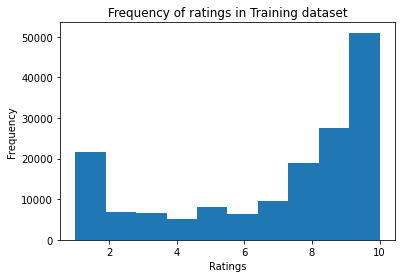

In [8]:
#Ratings histogram of the training dataset
plt.hist(drTrg['rating'],10)
plt.title("Frequency of ratings in Training dataset")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

#Ratings are not uniformly distributed (imbalanced data). Learning from imbalanced data is hard
#Consider ratings of 2,3 and 4 only 

In [9]:
#Subset the dataframe to obtain rows pertaining to ratings of 2,3 and 4 only

drTrgTop3 = drTrgWithoutNA.loc[(drTrgWithoutNA["rating"] == 2.0)  | (drTrgWithoutNA['rating'] == 3.0) | (drTrgWithoutNA['rating'] == 4.0)] #(18324,7)
print("Shape of the drugsCom Training dataset for poor ratings: ", drTrgTop3.shape) #(18324,7)

#Number of unique drug names - 1567
print("Number of unique drug names for poor ratings: ", len(drTrgTop3["drugName"].unique()))

#Number of unique conditions - 446
print("Unique medical conditions for poor ratings: ", len(drTrgTop3["condition"].unique()))

#Number of unique reviews - 12713
print("Unique review for poor ratings: ", len(drTrgTop3["review"].unique()))

#Number of ratings - 3 (2.0, 3.0, 4.0)
print("Unique ratings: ", sorted(drTrgTop3["rating"].unique()))

Shape of the drugsCom Training dataset for poor ratings:  (18324, 7)
Number of unique drug names for poor ratings:  1567
Unique medical conditions for poor ratings:  446
Unique review for poor ratings:  12713
Unique ratings:  [2.0, 3.0, 4.0]


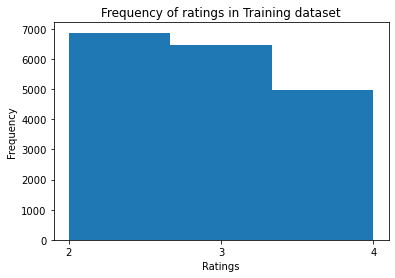

In [10]:
#Ratings histogram of the training dataset
plt.hist(drTrgTop3['rating'],3)
plt.title("Frequency of ratings in Training dataset")
plt.xlabel("Ratings")
plt.xticks(np.arange(2, 5, step=1))
plt.ylabel("Frequency")
plt.show()

#Though imbalanced, ratings are in the range of 5000-7000

In [11]:
#Function that accepts a dataframe and accepts two values for which frequency is to be found (col1, col2)
#and returns a dataframe with col3 and col4 as new column names
def valueCounts(data, col1, col2, col3, col4):
    
    getDF = data[[col1,col2]]
        
    newDF = pd.DataFrame(getDF[col1].value_counts())            #Get value counts and store in a dataframe
    newDF[col3] = newDF.index                                   #New column based on index
    newDF.rename(columns = {col1:col4}, inplace = True)         #Rename column 
    newDF = newDF[[col3, col4]]                                 #Rearrange columns in the dataframe
    newDF.reset_index(drop=True, inplace = True)                #Drop the index name
    
    return newDF

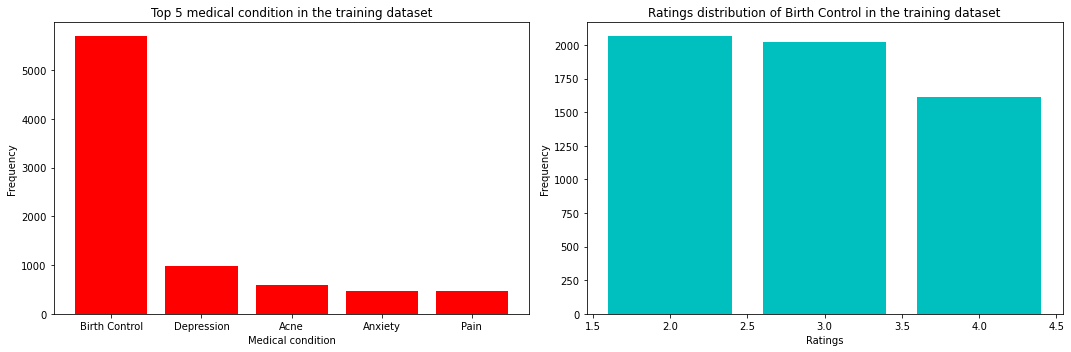

In [12]:
#let us subset the training data to explore for medical conditions and its ratings

#Call the function valueCounts
cond = valueCounts(drTrgTop3, "condition", "rating", "cond", "Frequency")
cond = cond.iloc[:5]                                             #Top 5 medical conditions

#Ratings for top medical condition (Birth Control)
topCond = drTrgTop3[drTrgTop3["condition"] == 'Birth Control']

ratTopCond = valueCounts(topCond, "rating", "review","ratings","Frequency")

#Plot barchart for top 5 medical conditions and ratings for the top condition in training dataset
fig, (ax1, ax2) =plt.subplots(ncols=2, figsize = (15,5))
ax1.bar(cond["cond"], cond["Frequency"], color = 'r')
ax1.set_xlabel("Medical condition")
ax1.set_ylabel("Frequency")
ax1.set_title("Top 5 medical condition in the training dataset")
ax2.bar(ratTopCond["ratings"], ratTopCond["Frequency"], color = 'c')
ax2.set_xlabel("Ratings")
ax2.set_ylabel("Frequency")
ax2.set_title("Ratings distribution of Birth Control in the training dataset")
fig.tight_layout()

#Birth control is the top medical condition in the training dataset
#Ratings distribution of birth control is not uniform in the training dataset

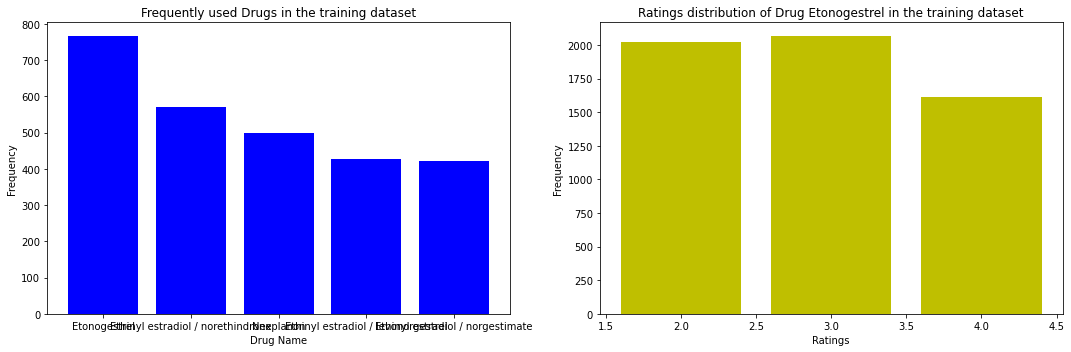

In [13]:
#let us subset the training data to explore drugs utilised and its ratings

#call the function valueCounts
drug = valueCounts(drTrgTop3, "drugName", "rating", "drug", "Frequency")

drugTop5 = drug.iloc[:5]   #Top 5 drug name occurence in the dataframe
drugLast5 = drug.iloc[:-5] #Last 5 drug name occurence in the dataframe


#Ratings for top drug (Etonogestrel)
topDrug = drTrgTop3[drTrgTop3["drugName"] == 'Etonogestrel']

#Call the function valueCounts 
ratTopDrug = valueCounts(topDrug, "rating", "review","ratings","Frequency")

#Plot barchart for top 5 medical conditions and ratings for the top condition in training dataset
fig, (ax1, ax2) =plt.subplots(ncols=2, figsize = (15,5))
ax1.bar(drugTop5["drug"], drugTop5["Frequency"], color = 'b')
ax1.set_xlabel("Drug Name")
ax1.set_ylabel("Frequency")
ax1.set_title("Frequently used Drugs in the training dataset")
ax2.bar(ratTopDrug["ratings"], ratTopCond["Frequency"], color = 'y')
ax2.set_xlabel("Ratings")
ax2.set_ylabel("Frequency")
ax2.set_title("Ratings distribution of Drug Etonogestrel in the training dataset")
fig.tight_layout()

#Rating distribution of most frequently used drug used is not uniform  in the training dataset

In [14]:
#Let us explore the review column in the training dataframe
print(list(drTrgTop3["review"].head(2)))

#Review contains special characters, sentence case, spelling mistakes, short forms, tags etc.

['"2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp; hurt! Leg/ankles aches   severe lower bowel preassure like you need to go #2 but can&#039;t! Enjoyed the initial rockhard erections but not at these side effects or $230 for months supply! I&#039;m 50 &amp; work out 3Xs a week. Not worth side effects!"', '"I had Crohn&#039;s with a resection 30 years ago and have been mostly in remission since.  Have recently had a bad flare and narrowing at the anastomosis and need to be on medication, but haven&#039;t found one that I can handle.  Asacol gave me such serious body aching and fatigue that I could not function.  Pentasa immediately gave me heart palpitations and arrhythmias so I had to discontinue it."']


In [15]:
print("Shape of the dataset: ", drTrgTop3.shape) #18324
print("Number of unique reviews: ", len(drTrgTop3["review"].unique())) #12713

#All reviews are not unique. Out of 18324 reviews only 12713 are unique.

Shape of the dataset:  (18324, 7)
Number of unique reviews:  12713


In [16]:
#Check whether for every unique review, the ratings are same

#Get value counts for each review in a dataframe 
rvwCnt = valueCounts(drTrgTop3, "review", "rating", "reviews", "Frequency")

#Sort them by frequency counts
rvwCntSorted = rvwCnt.sort_values(by = 'Frequency', ascending = False)

rvwCntSorted.head(5)

,reviews,Frequency
0,"""Did not work well for me.""",6
1,"""Limited improvement after 6 months, developed...",3
3735,"""I didn&#039;t really have a chance to find ou...",2
3743,"""I switched to the Nuvaring about 3 weeks ago ...",2
3742,"""Did not help with much pain maybe a slight bi...",2


In [17]:
#Check ratings for "Did not work well for me"
dnw = drTrgTop3[drTrgTop3["review"].str.contains("Did not work well for me")]
dnw.head(6)

#For the same review, ratings are different; two each for 2.0, 3.0 and 4.0. These reviews cannot be dropped.
#Observe for the same medical condition of migraine, drugName of cyclobenzaprine and for the same review, ratings are different 
#THIS WILL CREATE CHALLENGES IN MODEL CREATION, TESTING AND EVALUATION 

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
17022,17180,Flexeril,Migraine,"""Did not work well for me.""",2.0,"February 10, 2010",13
25049,193388,Cyclobenzaprine,Migraine,"""Did not work well for me.""",3.0,"March 6, 2010",13
34776,193541,Cyclobenzaprine,Migraine,"""Did not work well for me.""",2.0,"February 10, 2010",13
88692,193542,Cyclobenzaprine,Migraine,"""Did not work well for me.""",4.0,"February 10, 2010",8
106669,158364,Amrix,Migraine,"""Did not work well for me.""",3.0,"March 6, 2010",13
150280,158366,Amrix,Migraine,"""Did not work well for me.""",4.0,"February 10, 2010",8


In [18]:
#Drop duplicate rows as it does not contribute to training

#Sort the drTrgWithoutNA dataframe by rating
drTrgNoDup = drTrgTop3.sort_values('rating')

#Subset the dataframe by review and drop duplicate reviews by keeping the original
drTrgNoDup = drTrgNoDup.drop_duplicates(subset = 'review', keep = 'first')

#Shape of the unique reviews dataframe
print("Shape of dataframe with unique reviews: ", drTrgNoDup.shape) #12713 rows 

Shape of dataframe with unique reviews:  (12713, 7)


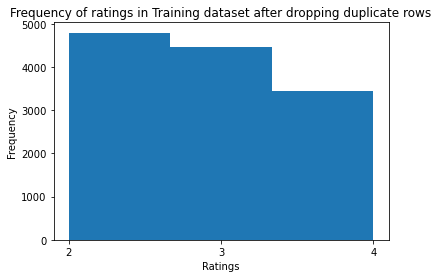

In [19]:
#Ratings histogram of the training dataset
plt.hist(drTrgNoDup['rating'],3)
plt.title("Frequency of ratings in Training dataset after dropping duplicate rows")
plt.xlabel("Ratings")
plt.xticks(np.arange(2, 5, step=1))
plt.ylabel("Frequency")
plt.show()

#Though imbalanced, ratings are in the range of 3500-5000

In [20]:
#Function to calculate the total number of words and vocabulary of a column in a dataframe or a list 
def WordsVocabCountDF(data):
    
    if isinstance(data, list):
        rowList = data
    else:
        rowList = data.tolist()          #Convert the dataframe column to a list
    words = []                      #Create an empty list
    for i in range(len(rowList)):   #For each row of the dataframe
        sents = rowList[i].split('.') #Get the entire sentence
        for j in range(len(sents)):   #For each sentence
            word = sents[j].split(' ') #Get all the words
            words.extend(word)         #Add the words to the list
    
    totWords = len(words) #Total number of Words 
    vocab = len(set(words)) #Returns vocabulary
    
    return totWords, vocab 

In [21]:
#Words and Vocabulary of the training corpus 

#Call the function WordsVocabCount
totWordsNA, vocabNA = WordsVocabCountDF(drTrgWithoutNA["review"])

print("Number of words in the training corpus after dropping NAs for all ratings: ", totWordsNA) #1,46,96,506 ( > 1.46 Cr words)
print("Vocabulary of the training corpus after dropping NAs for all ratings: ", vocabNA) #1,55,524 (> 1.5 lakh words)


totWordsTop3, vocabTop3 = WordsVocabCountDF(drTrgTop3["review"])
      
print("\nNumber of words in the training corpus - for poor ratings (2.0 to 4.0): ", totWordsTop3) #16,70,751 (> 16 Lakh words)
print("Vocabulary of the training corpus - for poor ratings(2.0 to 4.0): ", vocabTop3) #38,613 (>38,000 words)

Number of words in the training corpus after dropping NAs for all ratings:  14696506
Vocabulary of the training corpus after dropping NAs for all ratings:  155524

Number of words in the training corpus - for poor ratings (2.0 to 4.0):  1670751
Vocabulary of the training corpus - for poor ratings(2.0 to 4.0):  38613


In [22]:
#Find the average word length of a poor review

revList = drTrgTop3["review"].tolist()

#To check the number of words in a review
sumCnt = []
for texts in revList:                 #For every review
    sents = texts.split('.')          #Get the sentences
    cnt = 0                           #Counter for words
    for text in sents:                #For every sentence
        words = text.split(' ')       #Get the words
        wl = len(words)               #Number of words in the sentence
        cnt = cnt + wl                #Total words in the review
    sumCnt.append(cnt)                #Store total words in the review in a list

print("Number of words in the first 5 poor reviews: ", sumCnt[:5])
print("Total number of words in poor reviews: ", sum(sumCnt))
print("Total number of poor reviews: ", len(sumCnt))
print("Average words in a poor review: ", round(sum(sumCnt)/len(sumCnt),2), "; max word length: ", max(sumCnt), 
      "; min word length: ", min(sumCnt)) #Average words in a review: 91.18 words

Number of words in the first 5 poor reviews:  [72, 76, 118, 150, 165]
Total number of words in poor reviews:  1670751
Total number of poor reviews:  18324
Average words in a poor review:  91.18 ; max word length:  1956 ; min word length:  1


In [23]:
##########################################################################################
######################### STEP THREE: PREPROCESSING ######################################
##########################################################################################

In [24]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [25]:
def preprocess_text(sen):
    # Removing tags
    sentence = remove_tags(sen)
     # sentence = re.sub('<[^>]*>', '', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    #Convert to lowercase
    sentence = sentence.lower()
     
    return sentence

In [26]:
#Preprocess the reviews in the training data 
StepOne = []
sentences = list(drTrgTop3['review'])
for sen in sentences:
    StepOne.append(preprocess_text(sen))

In [27]:
print(StepOne[:10])

[' nd day on mg started to work with rock hard erections however experianced headache lower bowel preassure rd day erections would wake me up amp hurt leg ankles aches severe lower bowel preassure like you need to go but can enjoyed the initial rockhard erections but not at these side effects or for months supply m amp work out xs week not worth side effects ', ' had crohn with resection years ago and have been mostly in remission since have recently had bad flare and narrowing at the anastomosis and need to be on medication but haven found one that can handle asacol gave me such serious body aching and fatigue that could not function pentasa immediately gave me heart palpitations and arrhythmias so had to discontinue it ', ' have little bit of lingering cough from cold not giving me much trouble except keeps me up at night heard this was good so took so could get some sleep helped tremendously with the cough but then was having bad stomach cramps and diarrhea hadn eaten anything that 

In [28]:
#Check total number of words and vocabulary after preprocessing step one
print("Number of reviews: ", len(StepOne)) #18324

totWordsPP1, vocabPP1 = WordsVocabCountDF(StepOne)

print("\nNumber of words in the training corpus - after Step One preprocessing: ", totWordsPP1) #14,43,998 (Almost 14 Lakh words)
print("Vocabulary of the training corpus - after Step One preprocessing: ", vocabPP1) #16,257 (> 16,257 words)

#Vocabulary reduced by half while corpus has reduced by 2 lakh words

Number of reviews:  18324

Number of words in the training corpus - after Step One preprocessing:  1443998
Vocabulary of the training corpus - after Step One preprocessing:  16257


In [29]:
#Check for empty strings
'' in StepOne

False

In [30]:
def removeStopWords(sentence):
    
    word_tokens = word_tokenize(sentence)
    
    stop_words = set(stopwords.words('english'))
        
    sentence = [ w for w in word_tokens if not w in stop_words]
    
    sentence = ' '.join(sentence)
    
    return sentence

In [31]:
#Remove stop words from preprocessed text. #Takes few minutes to execute
StepTwo = []
sentences = StepOne
for sen in sentences:
    StepTwo.append(removeStopWords(sen))

In [32]:
print(StepTwo[:10])

['nd day mg started work rock hard erections however experianced headache lower bowel preassure rd day erections would wake amp hurt leg ankles aches severe lower bowel preassure like need go enjoyed initial rockhard erections side effects months supply amp work xs week worth side effects', 'crohn resection years ago mostly remission since recently bad flare narrowing anastomosis need medication found one handle asacol gave serious body aching fatigue could function pentasa immediately gave heart palpitations arrhythmias discontinue', 'little bit lingering cough cold giving much trouble except keeps night heard good took could get sleep helped tremendously cough bad stomach cramps diarrhea eaten anything upset stomach really feel like quot bug quot looked side effects delsym wish done first probably taken worked cough still get sleep due stomach issues', 'started nexplanon months ago minimal amount contraception take due inability take hormone used birth controls trying give time one o

In [33]:
#Check total number of words and vocabulary after preprocessing step two
print("Number of reviews: ", len(StepTwo)) #18324

totWordsPP2, vocabPP2 = WordsVocabCountDF(StepTwo)

print("\nNumber of words in the training corpus - after Step Two preprocessing: ", totWordsPP2) #7,37,171 (> 7 Lakh words)
print("Vocabulary of the training corpus - after Step Two preprocessing: ", vocabPP2) #16,107 (> 16,000 words)

#Total number of words has reduced by half while vocabulary is almost the same

Number of reviews:  18324

Number of words in the training corpus - after Step Two preprocessing:  737171
Vocabulary of the training corpus - after Step Two preprocessing:  16107


In [34]:
#Check for empty strings
'' in StepTwo

False

In [35]:
#Store the preprocessed Sentiments and corresponding ratings in a dataframe
preProcList = list(zip(StepTwo, drTrgTop3['rating']))

#Convert this list to a dataframe
preProcDF = pd.DataFrame(preProcList, columns=['review','rating'])

#Shape of the dataframe. #(18324,2)
preProcDF.shape

(18324, 2)

In [36]:
##########################################################################################
######################### STEP FOUR: MODEL SELECTION #####################################
##########################################################################################

In [37]:
#Preprocessed Training data shall be used for training and validation of the models
#Test data shall not be used
#Scale down the label values

#Training Features for total reviews are stored in X
X = preProcDF["review"]
#Training Classes for total reviews are stored in y
yorig = preProcDF['rating']
#Scale down the values from [2.0, 3.0, 4.0] to [0.0, 1.0, 2.0]
y = yorig.apply(lambda row: row - 2)
y.unique()

array([0., 2., 1.])

In [38]:
#Libraries for Neural Network Classifiers

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
#Neural Network classifier (90% for training and 10% for validation)
xtrain, xval, ytrain, yval = train_test_split(X,y, test_size=0.1, random_state=42)

In [40]:
#Hyper parameters settings

EMBEDDING_DIMENSION = 100
VOCABULARY_SIZE = 5000
MAX_LENGTH = 100
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [41]:
#Split sentence into words using tokenizer

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(list(xtrain) + list(xval))

In [42]:
print("Vocabulary: ", len(tokenizer.word_index))

Vocabulary:  16108


In [43]:
#Convert words into sequences for training dataset

xtrain_sequences = tokenizer.texts_to_sequences(xtrain)
xval_sequences = tokenizer.texts_to_sequences(xval)
word_index = len(tokenizer.word_index) + 1
#print('Vocabulary size:', word_index)
#print(xtrain[2])
#print(xtrain_sequences[1])

In [44]:
#Pad sequences so that all words are represented as 100 length vector with 64 embedding dimensions

xtrain_pad = sequence.pad_sequences(xtrain_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
xval_pad = sequence.pad_sequences(xval_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
#print(xtrain_pad[0,:])

In [45]:
#First Keras Model with Embedding

model = Sequential()
model.add(tensorflow.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
model.add(tensorflow.keras.layers.Flatten())
model.add(tensorflow.keras.layers.Dense(64, activation='relu'))
model.add(tensorflow.keras.layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,140,259
Trainable params: 1,140,259
Non-trainable params: 0
_________________________________________________________________


In [46]:
#Takes few minutes to train 11,40,259 parameters for 50 epochs
history = model.fit(xtrain_pad, ytrain,
                    epochs=50,
                    validation_data=(xval_pad, yval),
                    verbose=False)

In [47]:
lossTrg, accTrg = model.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy: {:.4f}".format(accTrg)) #99.86% (Overfitting?)
lossVal, accVal = model.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accVal)) #72.61%

Training Accuracy: 0.9986
Validation Accuracy:  0.7261


In [48]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

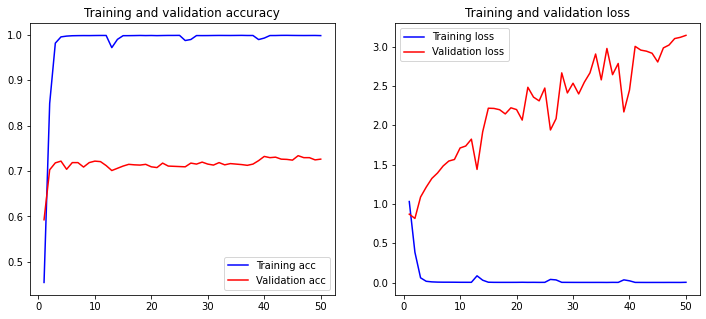

In [49]:
plot_history(history)
#Training and validation accuracy increases rapidly in the first few epochs. After that it stabilises
#Validation loss is increasing after the second epoch. Model is overfitting

In [50]:
#Add GlobalMaxPool1D layer between Embedding layer and hidden layer to downsample the feature vectors
model2 = Sequential()
model2.add(tensorflow.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
model2.add(tensorflow.keras.layers.GlobalMaxPool1D())
model2.add(tensorflow.keras.layers.Dense(64, activation='relu'))
model2.add(tensorflow.keras.layers.Dense(3, activation='softmax'))

In [51]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 506,659
Trainable params: 506,659
Non-trainable params: 0
_________________________________________________________________


In [52]:
#Fit the model with Global MaxPooling 1D layer and train for 50 epochs. Note number of parameters have come down to 506,659
#Takes few minutes to train
history2 = model2.fit(xtrain_pad, ytrain,
                    epochs=50,
                    validation_data=(xval_pad, yval), verbose = False
                    )

In [54]:
#Training and Validation loss of model with Global Max Pooling layer
lossMP, accTrgMP = model2.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy Max Pooling: {:.4f}".format(accTrgMP)) #99.73%
loss2, accValMP = model2.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy Max Pooling:  {:.4f}".format(accValMP)) #71.47%

Training Accuracy Max Pooling: 0.9973
Validation Accuracy Max Pooling:  0.7147


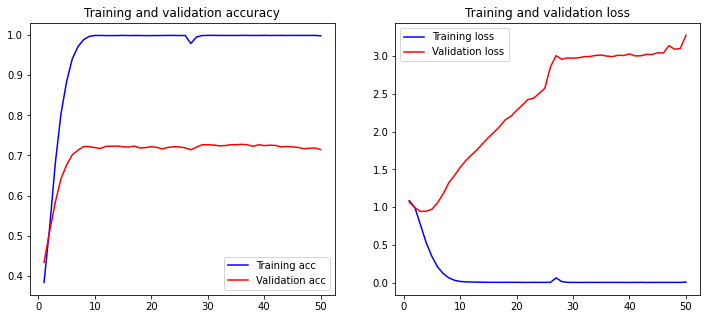

In [55]:
plot_history(history2)
#Training and validation accuracy increases rapidly in the first 5 epochs. Then stabilises
#Validation loss increases from the fifth epoch or so while training loss decreases till about 8th epoch. Then stabilises
#Model continues to overfit

In [56]:
#Use pretrained GloVe Word Embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    f = open('glove.6B.100d.txt', encoding = 'utf-8')
    for line in f:
        word, *vector = line.split()
        if word in word_index:
            idx = word_index[word] 
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [57]:
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt',tokenizer.word_index, EMBEDDING_DIMENSION)
print("Number of vectors in the embedding matrix: ", len(embedding_matrix))

Number of vectors in the embedding matrix:  16109


In [58]:
#Add Embedding Matrix in the Embedding layer and make the layer non-trainable
model3 = Sequential()
model3.add(tensorflow.keras.layers.Embedding(input_dim=(len(tokenizer.word_index) + 1), output_dim=EMBEDDING_DIMENSION, 
                                             weights = [embedding_matrix], input_length=MAX_LENGTH, trainable = False))
model3.add(tensorflow.keras.layers.GlobalMaxPool1D())
model3.add(tensorflow.keras.layers.Dense(64, activation='relu'))
model3.add(tensorflow.keras.layers.Dense(3, activation='softmax'))

In [60]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()
#Number of trainable parameters reduced to 6659 out of 16,17,559 as GloVe word embedding layer is made non-trainable

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1610900   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 1,617,559
Trainable params: 6,659
Non-trainable params: 1,610,900
_________________________________________________________________


In [61]:
#Fit the model with GloVe Word Embedding and train for 50 epochs. Takes more than a minute
history3 = model3.fit(xtrain_pad, ytrain,
                    epochs=50,
                    validation_data=(xval_pad, yval), verbose = False
                    )

In [62]:
#Training and Validation loss of model with GloVe Word Embedding
lossGWE, accTrgGWE= model3.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy GloVe Word Embedding Non-trainable: {:.4f}".format(accTrgGWE)) #49.11%
lossGWE, accValGWE = model3.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy GloVe Word Embedding Non-trainable:  {:.4f}".format(accValGWE)) #41.57%

Training Accuracy GloVe Word Embedding Non-trainable: 0.4911
Validation Accuracy GloVe Word Embedding Non-trainable:  0.4157


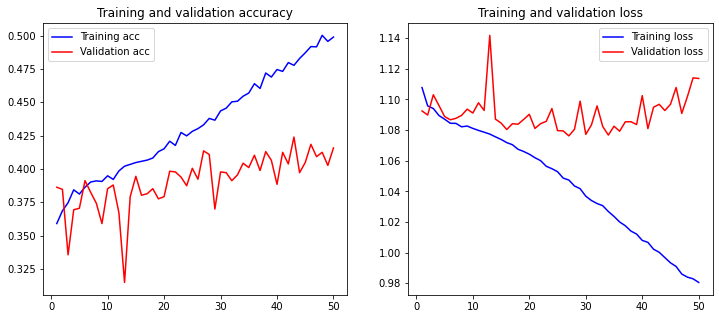

In [63]:
plot_history(history3)
#Training and Validation accuracy increases every epoch while oscillating
#Training loss reduces but validation error oscillates while remaining higher than the training loss

In [64]:
#Allow the GloVe embedding layer to be trained. Check performance

model4 = Sequential()
model4.add(tensorflow.keras.layers.Embedding(input_dim=(len(tokenizer.word_index) + 1), output_dim=EMBEDDING_DIMENSION, 
                                             weights = [embedding_matrix], input_length=MAX_LENGTH, trainable = True))
model4.add(tensorflow.keras.layers.GlobalMaxPool1D())
model4.add(tensorflow.keras.layers.Dense(64, activation='relu'))
model4.add(tensorflow.keras.layers.Dense(3, activation='softmax'))

In [65]:
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.summary()
#Number of trainable parameters increases to 16,17,559 as GloVe word embedding layer is made trainable

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1610900   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 1,617,559
Trainable params: 1,617,559
Non-trainable params: 0
_________________________________________________________________


In [66]:
#Fit the model with GloVe Word Embedding trainable and train for 50 epochs
#Takes few minutes as over 16 lakh parameters to be trained 
history4 = model4.fit(xtrain_pad, ytrain,
                    epochs=50,
                    validation_data=(xval_pad, yval), verbose = False
                    )

In [67]:
#Training and Validation loss of model with GloVe Word Embedding Trainable
lossGWET, accTrgGWET= model4.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy GloVe Word Embedding Trainable: {:.4f}".format(accTrgGWET)) #99.87%
lossGWET, accValGWET = model4.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy GloVe Word Embedding Trainable:  {:.4f}".format(accValGWET)) #71.14%

Training Accuracy GloVe Word Embedding Trainable: 0.9987
Validation Accuracy GloVe Word Embedding Trainable:  0.7114


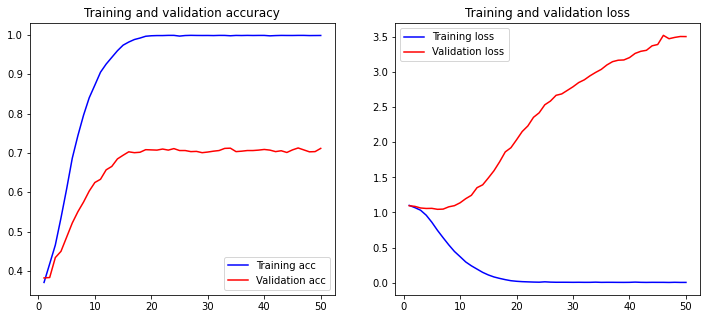

In [68]:
plot_history(history4)
#Training and Validation accuracy increases steadily upto 15 epochs. Then plateaus.
#Training accuracy is close to 100% (Overfitting) while validation accuracy is 71%
#Validation loss increases rapidly from the 10th epoch onwards

In [69]:
#Convolutional Neural Networks with vocabulary_size of 5000
modelC1 = Sequential()
modelC1.add(tensorflow.keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
modelC1.add(tensorflow.keras.layers.Conv1D(128, 5, activation='relu'))
modelC1.add(tensorflow.keras.layers.GlobalMaxPooling1D())
modelC1.add(tensorflow.keras.layers.Dense(10, activation='relu'))
modelC1.add(tensorflow.keras.layers.Dense(4, activation='softmax'))

In [70]:
modelC1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelC1.summary()
#Number of trainable parameters is 565,462

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 44        
Total params: 565,462
Trainable params: 565,462
Non-trainable params: 0
_________________________________________________________________


In [71]:
#Train the CNN model with vocabulary of 5000 words for 10 epochs.Takes a minute to train
historyC1 = modelC1.fit(xtrain_pad, ytrain,
                    epochs=10,
                    validation_data=(xval_pad, yval), verbose = False
                    )

In [72]:
#Training and Validation loss of Convolutinal Neural Network
lossC1, accTrgC1= modelC1.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy CNN with vocabulary 5000 : {:.4f}".format(accTrgC1)) #99.49%
lossC1, accValC1 = modelC1.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy CNN with vocabulary 5000:  {:.4f}".format(accValC1)) #67.48%

Training Accuracy CNN with vocabulary 5000 : 0.9949
Validation Accuracy CNN with vocabulary 5000:  0.6748


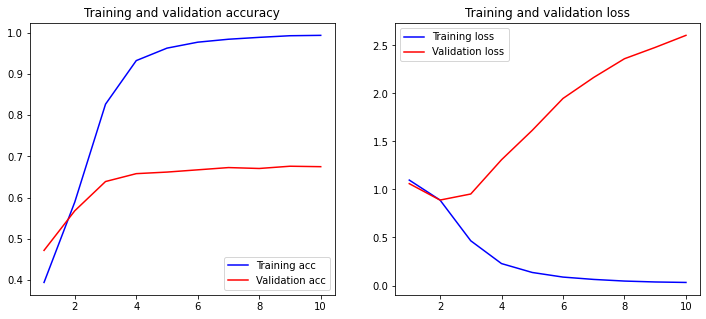

In [73]:
plot_history(historyC1)
#Training and Validation accuracy increases for the first 5 epochs and then stabilises
#Training accuracy is close to 100% (overfitting) while validation accuracy is 67.48%
#Validation loss increases after 3 epochs while training loss reduces and approaches zero

In [74]:
#Convolutional Neural Networks with vocabulary_size of corpus (16109 instead of 5000 set earlier)
modelC2 = Sequential()
modelC2.add(tensorflow.keras.layers.Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
modelC2.add(tensorflow.keras.layers.Conv1D(128, 5, activation='relu'))
modelC2.add(tensorflow.keras.layers.GlobalMaxPooling1D())
modelC2.add(tensorflow.keras.layers.Dense(10, activation='relu'))
modelC2.add(tensorflow.keras.layers.Dense(4, activation='softmax'))

In [76]:
modelC2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelC2.summary()
#Number of trainable parameters is 16,76,362

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1610900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 44        
Total params: 1,676,362
Trainable params: 1,676,362
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Over 16 Lakh parameters to be trained for 10 epochs. Takes few minutes
historyC2 = modelC2.fit(xtrain_pad, ytrain,
                    epochs=10,
                    validation_data=(xval_pad, yval), verbose = False
                    )

In [78]:
#Training and Validation loss of Convolutinal Neural Network
lossC2, accTrgC2= modelC2.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy CNN (Corpus Vocabulary): {:.4f}".format(accTrgC2)) #99.86%
lossC2, accValC2 = modelC2.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy CNN (Corpus Vocabaulary):  {:.4f}".format(accValC2)) #71.96%

Training Accuracy CNN (Corpus Vocabulary): 0.9986
Validation Accuracy CNN (Corpus Vocabaulary):  0.7196


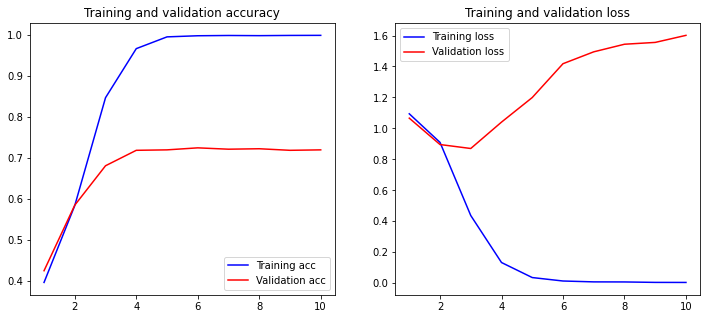

In [79]:
plot_history(historyC2)
#Model continues to overfit the training data with best validation accuracy of 72.07%
#Validation loss is increasing rapidly after three epochs

In [80]:
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

In [81]:
#Recurrent Neural Network
def RNN():
    inputs = Input(name='inputs',shape=[MAX_LENGTH])
    layer = Embedding(5000,50,input_length=MAX_LENGTH)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [82]:
modelrnn = RNN()
modelrnn.summary()
modelrnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#Training parameters - 296,851

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 50)           250000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                

In [83]:
#Each epoch takes roughly 20 seconds. For 50 epochs, approximately 18 minutes
histrnn = modelrnn.fit(xtrain_pad,ytrain,batch_size=128,epochs=50, validation_data=(xval_pad, yval), verbose=False)

In [84]:
#Training and Validation loss of Recurrent Neural Network
lossrnn, accTrgrnn= modelrnn.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy RNN: {:.4f}".format(accTrgrnn)) #97.13%
lossValrnn, accValrnn = modelrnn.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy RNN:  {:.4f}".format(accValrnn)) #68.58%

Training Accuracy RNN: 0.9713
Validation Accuracy RNN:  0.6858


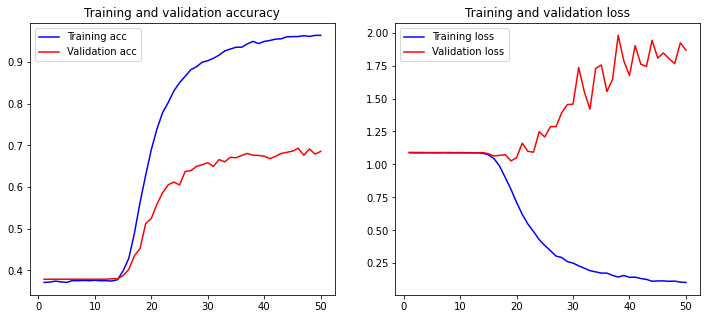

In [85]:
plot_history(histrnn)
#Training and validation accuracy increases rapidly after 15 epochs. But validation accuracy is much lesser than training accuracy
#Training and validation loss is steadily reducing. Validation loss increases after 20 epochs.

In [86]:
#Load libraries for Bidirectional LSTM Models
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Bidirectional

In [87]:
#Create Bidirectional LSTM model

modelBL = Sequential()
modelBL.add(tensorflow.keras.layers.Embedding(len(tokenizer.word_index) + 1, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
modelBL.add(SpatialDropout1D(0.3))
modelBL.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.3)))
modelBL.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
modelBL.add(Dropout(0.8))
modelBL.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
modelBL.add(Dropout(0.8))
modelBL.add(Dense(3))
modelBL.add(Activation('softmax'))

In [88]:
modelBL.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [89]:
modelBL.summary()
#Training parameters - 18,02,203

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1610900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

In [90]:
#Each epoch takes approximately 2 minutes. For 10 epochs, approximately 20 minutes required for fitment of model
num_epochs = 10
historyBL = modelBL.fit(xtrain_pad, ytrain, epochs=num_epochs, validation_data=(xval_pad, yval), verbose = False)

In [91]:
#Training and Validation loss of Bidirectional LSTM Model
lossBM, accTrgBM= modelBL.evaluate(xtrain_pad, ytrain, verbose=False)
print("Training Accuracy Bidrectional LSTM (Corpus Vocabulary): {:.4f}".format(accTrgBM)) #77.36%
lossValBM, accValBM = modelBL.evaluate(xval_pad, yval, verbose=False)
print("Validation Accuracy Bidirectional LSTM (Corpus Vocabaulary):  {:.4f}".format(accValBM)) #54.23%

Training Accuracy Bidrectional LSTM (Corpus Vocabulary): 0.7736
Validation Accuracy Bidirectional LSTM (Corpus Vocabaulary):  0.5423


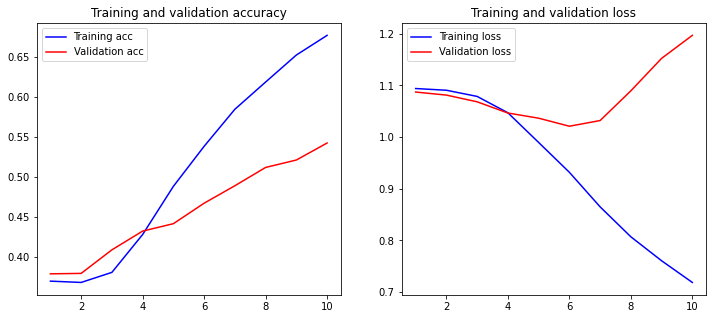

In [92]:
plot_history(historyBL)
#Training and validation accuracy is increasing every epoch. 
#Validation loss decreases for 6 epochs and then increases while training loss decreasing steadily

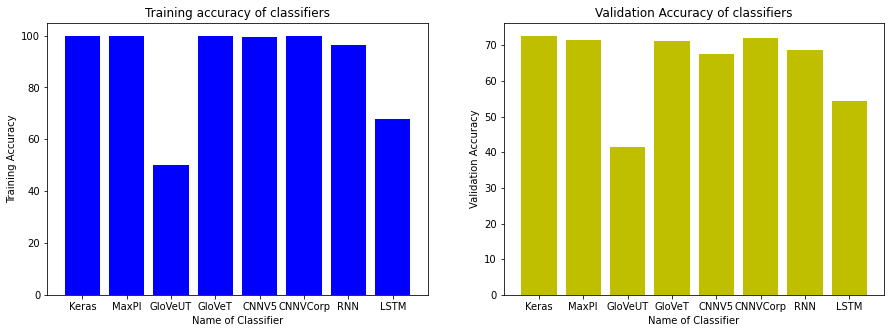

In [93]:
#Training and validation accuracy of all classifiers in one dataframe 

fkmL = ["Keras", (history.history["accuracy"][-1])*100, (history.history["val_accuracy"][-1])*100]
skmL = ["MaxPl", (history2.history["accuracy"][-1])*100, (history2.history["val_accuracy"][-1])*100]
ntkmL = ["GloVeUT", (history3.history["accuracy"][-1])*100, (history3.history["val_accuracy"][-1])*100]
tkmL = ["GloVeT", (history4.history["accuracy"][-1])*100, (history4.history["val_accuracy"][-1])*100]

cnn1 = ["CNNV5", (historyC1.history["accuracy"][-1])*100, (historyC1.history["val_accuracy"][-1])*100]
cnn2 = ["CNNVCorp", (historyC2.history["accuracy"][-1])*100, (historyC2.history["val_accuracy"][-1])*100]

rnn = ["RNN", (histrnn.history["accuracy"][-1])*100, (histrnn.history["val_accuracy"][-1])*100]
bm = ["LSTM", (historyBL.history["accuracy"][-1])*100, (historyBL.history["val_accuracy"][-1])*100]

listAcc = [fkmL, skmL, ntkmL, tkmL, cnn1, cnn2, rnn, bm]

accDF = pd.DataFrame(listAcc, columns = ["Name of Classifier","Training Accuracy", "Validation Accuracy"])

#Plotting training and validation accuracy
fig, (ax1, ax2) =plt.subplots(ncols=2, figsize = (15,5))
ax1.bar(accDF["Name of Classifier"], accDF["Training Accuracy"], color = 'b')
ax1.set_xlabel("Name of Classifier")
ax1.set_ylabel("Training Accuracy")
ax1.set_title("Training accuracy of classifiers")
ax2.bar(accDF["Name of Classifier"], accDF["Validation Accuracy"], color = 'y')
ax2.set_xlabel("Name of Classifier")
ax2.set_ylabel("Validation Accuracy")
ax2.set_title("Validation Accuracy of classifiers")
plt.show()

In [94]:
accDF

,Name of Classifier,Training Accuracy,Validation Accuracy
0,Keras,99.848402,72.613204
1,MaxPl,99.793828,71.467537
2,GloVeUT,49.893883,41.571194
3,GloVeT,99.860531,71.140206
4,CNNV5,99.326903,67.484999
5,CNNVCorp,99.872661,71.958536
6,RNN,96.458673,68.576103
7,LSTM,67.697531,54.228044


In [95]:
#Discussion on results of classifiers

#Training accuracy is nearly 100% is for all models except GloVe Model (not trainable) and Bidirectional LSTM
#Highest validation accuracy of 72.61% is for basic keras model

#Based on the results obtained, CNN with corpus vocabulary is chosen as the best classifier 

In [96]:
#######################################################################################
############## STEP FIVE: PREPARE TEST DATA ###########################################
#######################################################################################

In [97]:
#Shape of the test dataframe: (53766, 7); NAs - 295
print("Shape of the drugsCom Test dataset: ", drTest.shape)
print("\nNAs in the drugsCom Test dataset: ", drTest.isna().sum())

#Number of unique drug names - 2637
print("\nNumber of unique drug names in the Test dataset: ", len(drTest["drugName"].unique()))

#Number of unique conditions - 709; NAs - 295
print("Unique medical conditions in the Test dataset: ", len(drTest["condition"].unique()))

#Number of unique reviews - 48280; NAs - 0
print("Unique review in the Test dataset: ", len(drTest["review"].unique()))

#Number of ratings - 10 (1.0 to 10.0); NAs - 0
print("Unique rating in the Test dataset: ", sorted(drTest["rating"].unique()))

#Drop rows containing NAs
drTestWithoutNA = drTest.dropna()

#Shape of the dataframe without NAs (53471,7)
print("\nShape of the drugsCom Test dataset without NAs: ", drTestWithoutNA.shape)

Shape of the drugsCom Test dataset:  (53766, 7)

NAs in the drugsCom Test dataset:  Unnamed: 0       0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

Number of unique drug names in the Test dataset:  2637
Unique medical conditions in the Test dataset:  709
Unique review in the Test dataset:  48280
Unique rating in the Test dataset:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Shape of the drugsCom Test dataset without NAs:  (53471, 7)


In [98]:
drTestTop3 = drTestWithoutNA.loc[(drTestWithoutNA["rating"] == 2.0)  | (drTestWithoutNA['rating'] == 3.0) | (drTestWithoutNA['rating'] == 4.0)] #(18324,7)
print("Shape of the drugsCom Test dataset for poor ratings: ", drTrgTop3.shape) #(18324,7)

#Number of unique drug names - 1053
print("Number of unique drug names for poor ratings: ", len(drTestTop3["drugName"].unique()))

#Number of unique conditions - 331
print("Unique medical conditions for poor ratings: ", len(drTestTop3["condition"].unique()))

#Number of unique reviews - 5552
print("Unique review for poor ratings: ", len(drTestTop3["review"].unique()))

#Number of ratings - 3 (2.0, 3.0, 4.0)
print("Unique ratings: ", sorted(drTestTop3["rating"].unique()))

Shape of the drugsCom Test dataset for poor ratings:  (18324, 7)
Number of unique drug names for poor ratings:  1053
Unique medical conditions for poor ratings:  331
Unique review for poor ratings:  5552
Unique ratings:  [2.0, 3.0, 4.0]


In [99]:
#Preprocess the reviews in the test data 
StepOneTest = []
sentences = list(drTestTop3['review'])
for sen in sentences:
    StepOneTest.append(preprocess_text(sen))

In [100]:
#Remove stop words from preprocessed text
StepTwoTest = []
sentences = StepOneTest
for sen in sentences:
    StepTwoTest.append(removeStopWords(sen))

In [101]:
StepTwoTest[:1]

['days first weeks using arms face put vaseline lips eyes nostrils protect cream far reaction know many pre cancer thought would light like christmas tree far good maybe coming time tell']

In [102]:
#Check for empty strings in test data
'' in StepTwoTest

False

In [103]:
#Store the preprocessed test reviews and corresponding ratings in a dataframe
preProcListTest = list(zip(StepTwoTest, drTestTop3['rating']))

#Convert this list to a dataframe
preProcDFTest = pd.DataFrame(preProcListTest, columns=['review','rating'])

#Shape of the dataframe
preProcDFTest.shape #(6163,2)

(6163, 2)

In [104]:
preProcDFTest.head()

,review,rating
0,days first weeks using arms face put vaseline ...,4.0
1,pill almost two years work far getting pregnan...,2.0
2,ditto rebound sleepless discontinued done stra...,2.0
3,ginanvi months switched pill due high cost gin...,3.0
4,actos almost year gained pounds swelling hands...,4.0


In [105]:
#Test Classes for total reviews are stored in ytest
ytest = preProcDFTest['rating']
#Scale down the values from [2.0, 3.0, 4.0] to [0.0, 1.0, 2.0]
ytest = ytest.apply(lambda row: row - 2)
ytest.unique()

array([2., 0., 1.])

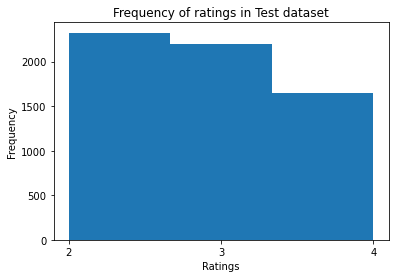

In [106]:
#Ratings histogram of the test dataset
plt.hist(preProcDFTest['rating'],3)
plt.title("Frequency of ratings in Test dataset")
plt.xlabel("Ratings")
plt.xticks(np.arange(2, 5, step=1))
plt.ylabel("Frequency")
plt.show()

#Though imbalanced, ratings are in the range of 1500-2500

In [107]:
#Test data to be tokenized, embedded like training data
xtest = preProcDFTest['review']

#Split sentence into words using tokenizer
tokenizerTest = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizerTest.fit_on_texts(list(xtest))

In [108]:
#Convert words into sequences for training dataset

xtest_sequences = tokenizerTest.texts_to_sequences(xtest)
word_index_test = len(tokenizerTest.word_index) + 1

#Pad sequences so that all words are represented as 100 length vector with 64 embedding dimensions

xtest_pad = sequence.pad_sequences(xtest_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)

In [109]:
xtest_pad[:1]

array([[  10,    8,   21,  124,  722,  155,   76, 3828, 1274,  392, 3829,
        3418,  448,  163,  393,   95,  192, 1341, 1126,  101,   17,  198,
           7, 3419, 4407,  163,   71,  262,  386,   11,  375,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])

In [110]:
#######################################################################################
############## STEP SIX: EVALUATE TEST DATA ###########################################
#######################################################################################

In [111]:
#Use CNN model(Corpus Vocabulary) with best validation accuracy for preprocessed test data
predictions = modelC2.predict(xtest_pad, verbose=1)

193/193 [==============================] - 1s 5ms/step


In [112]:
#Obtain the predictions with labels as 2,1,0 as used for training
labels = [2,1,0]
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [113]:
print(prediction_labels[:5])

[2, 1, 2, 2, 2]


In [114]:
#Increase the prediction label by 2 for each element
revPred = [prediction_labels[i] + 2 for i in range(len(prediction_labels))]
print(prediction_labels[:5], revPred[:5])

[2, 1, 2, 2, 2] [4, 3, 4, 4, 4]


In [115]:
#Calculate accuracy of test data
from sklearn import metrics
print(metrics.accuracy_score(preProcDFTest['rating'], revPred)) #31.14% accuracy for unseen test data

0.3113743306831089


In [116]:
#Classification report
from sklearn.metrics import classification_report

In [117]:
print("Classification Report for CNN Model with Corpus Vocabulary on Test Data")
target_names = ['rating 2', 'rating 3','rating 4']
print(classification_report(preProcDFTest['rating'], revPred, target_names=target_names))

Classification Report for CNN Model with Corpus Vocabulary on Test Data
              precision    recall  f1-score   support

    rating 2       0.38      0.15      0.22      2324
    rating 3       0.37      0.28      0.32      2197
    rating 4       0.27      0.58      0.36      1642

    accuracy                           0.31      6163
   macro avg       0.34      0.34      0.30      6163
weighted avg       0.35      0.31      0.29      6163



In [118]:
#The best model (CNN with corpus vocabulary) produces a training accuracy of 99.9% and validation accuracy of 71.96%
#Even with the best model, accuracy on test data is 31% approximately

#Probable reasons
#Not enough training samples (Total 18324 samples for three ratings)
#Data does not generalise well
#Missing focus on hyperparameters